# Diabetic Retinopathy Detection

This Jupyter Notebook uses a neural network to classify retinal images for various stages of diabetic retinopathy, a disease which can lead of blindness.

Reference:
* Kaggle Competition: [APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection)
* My Convolutional Neural Network (CNN) is based upon the CNN defined by: [SmallerVGGNet by Adrian Rosebrock, PyImageSearch](https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns)

## Approach
* The dataset is provided as a part of the Kaggle competition:
    * 3662 training images, with an associated CSV file containing ID code and label class for each image
    * 1928 testing images (which I refer to as "official test" images), with an associated CSV file containing only the ID code for each image. Note: a subset of a broader set of testing images that will be used to calculate official scoring for the competition
    * Each image was a color image, but with size/resolution ranging from 474x358 to 3388x2588 pixels.
    
* I divided the 3662 training images into 3 sets using sklearn `test_train_split`:
    * 2197 (60%) for training
    * 732 (20%) for validation
    * 732 (20%) for evaluation of model accuracy.
    
* <font color="blue"><b>REFACTORED</b></font>: Now using the Keras `ImageDataGenerator` method `flow_from_dataframe` to access the training, validation, and testing images.
    * The train.csv file provides the image `id_code` and associated `diagnosis`.  This file is read into a dataframe.
    * `flow_from_dataframe` is then used to ready the images associated with the `id_code` entries in the dataframe.
        
* I defined and refined the Convolutional Neural Network:
    * Defined the CNN model as a class based initially upon `SmallerVGGNet` (Adrian Rosebrock) and subsequently revised to refine the model's accuracy
    * Used Keras `DataImageGenerator` and `flow_from_dataframe` to instantiate image generators linked to the training, validation, and Testing directories
    * Initialized the model using the defined class and compiled it (specifying the Adam optimizer)
    * Fit the model using the training image generator, with validation using the model using the validation image generator
    * The Fit History, providing accuracy and loss at each epoch, was plotted
    * The fitted model was then used to predict the class for each of the Official Test images
    
* To improve the robustness of the model, the `DataImageGenerator` instantiated for training was revised to add augmentation to introduce random rotations, translations, and other transformations of the training images used to fit the model.
    
## Results
* Refer to the Figure provided below
* For the neural network definition specified in this notebook, the fitting history shows a maximum training accuracy of 0.702 at epoch 8 (the 9th epoch iteration).  The fitted model yielded an accuracy of 0.5829 with the validation data, with a major dip in validation accurance and loss at epoch 5.  Accuracy and loss decrease with epoch 6 for both training and validation data, suggesting that overfitting may be an issue after this iteration.
* Across all of the CNN models I attempted, the performance of the model against the official test data was poor, with Kaggle indicating a maximum accurancy of 0.486 for the "Private" dataset that is not available while the competition is in-progress.  However, while this is sufficient for any meaningful real-world usage, it's reassuring that the model at least performed better than a random guess of the image class (e.g., 1/5 = 0.200)!

## Opportunities for Further Investigation
* Further investigation of the effects of changes in each layer of the CNN is needed.
* I did not check for skew in the distribution of classes in the training images.  Taking this into account during sample selection and during fitting could improve results


| Figure: Diabetic Retinopathy Detection - Model Fitting History |
|----------|
| ![Figure: Diabetic Retinopathy Detection - Model Fitting History is Loading...](docs/Figure-DPA_Fit_History.png "Figure: Diabetic Retinopathy Detection - Model Fitting History") |
| ![Table: Diabetic Retinopathy Detection - Model Fitting History is Loading...](docs/Table-DPA_Fit_History.png "Table: Diabetic Retinopathy Detection - Model Fitting History") |

# Dependencies

In [1]:
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D    # Support 3D graphing

import numpy as np
import pandas as pd
from pandas.plotting import table
import math
import random
import shutil
import os

# from imutils import paths
# import argparse
# import pickle
# import cv2

from pprint import pprint

# Visualization
import graphviz
import pydotplus
from IPython.display import Image

# Machine Learning - Data Preparation and Pre-Processing
from sklearn.model_selection import train_test_split # Split data into training and testing samples
from sklearn.model_selection import cross_val_score  # Score a model using k-fold or other cross validation

from sklearn.preprocessing import OneHotEncoder   # Convert categorical integer features (X) to One-Hot encoded values
from sklearn.preprocessing import LabelEncoder    # Convert categorical labeled values to categorical integer values
from sklearn.preprocessing import LabelBinarizer  # Convert categorical labeled values to Binary encoded values

from sklearn.preprocessing import StandardScaler  # Scale numerical features to standard normal distribution
from sklearn.preprocessing import MinMaxScaler    # Scale numerical values based upon mix/max values

# Machine Learning - Sci-Kit Learn - Models - Regression
from sklearn.linear_model import LinearRegression  # TBD
from sklearn.linear_model import Lasso             # TBD
from sklearn.linear_model import Ridge             # TBD
from sklearn.linear_model import ElasticNet        # TBD

# Machine Learning - Sci-Kit Learn - Models - Classification
from sklearn.linear_model import LogisticRegression   # Logistic Regression Classifier
from sklearn import tree                              # Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier   # Random Forest Classifier
from sklearn import svm                               # Support Vector Machine Classifier
from sklearn.neighbors import KNeighborsClassifier    # K-Nearest Neighbors (KNN)

# Machine Learning - GridSearch for Hyper-Parameter tuning
from sklearn.model_selection import GridSearchCV      # Grid Search

# Machine Learning - Quantify Model Performance
from sklearn.metrics import mean_squared_error    # Mean Squared Error (MSE) metric
from sklearn.metrics import r2_score              # R-squared (Coefficient of Determination) metric
from sklearn.metrics import confusion_matrix      # Generate a confusion matrix (actual vs. predicted counts)
from sklearn.metrics import classification_report # Calculate metrics for prediction performance
from sklearn.metrics import accuracy_score        # Calculate the precision: (Tp+Tn) / (Tp + Fp + Tn + Fn) => Ability Correctly Predict samples
from sklearn.metrics import precision_score       # Calculate the precision: Tp / (Tp + Fp) => Ability to avoid false negatives
from sklearn.metrics import recall_score          # Calculate the recall: Tp / (Tp + Fn) => Ability to find all positive samples
from sklearn.metrics import f1_score              # Calculate the F1 score: 2*(precision*recall)/(precision+recall)

# Machine Learning - Dataset Generation
from sklearn.datasets import make_regression     # Generate linear data
from sklearn.datasets import make_s_curve        # Generate nonlinear data
from sklearn.datasets import make_blobs          # Generate blobs for classification
from sklearn.datasets import make_circles        # Generate circles for classification
from sklearn.datasets import load_iris           # Sample multi-class dataset for classification
from sklearn.datasets import make_classification # Generate datasets for classification

# Machine Learning - Keras (Tensorflow) - Models
from keras.models import Sequential               # Sequential model serving as foundation for neural network
# from keras.layers import Dense                    # Nodes for specifying input, hidden, and output layers
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense

# Machine Learning - Keras (Tensorflow) - Convolutional Neural Networks (Image Classification)
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K

# Machine Learning - Keras (Tensorflow) - Optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam

# Machine Learning - Keras (Tensorflow) - Encoding
from keras.utils import to_categorical            # One-Hot Encoder provided through Keras

# Machine Learning - Keras (Tensorflow) - Other related Tools
from keras.utils import plot_model                # Plot a neural network model
from keras.models import load_model               # Load a saved machine learning model
from keras.preprocessing import image             # Loads an image for application of machine learning
from keras.preprocessing.image import img_to_array # Converts an image to a numpy array
from keras.preprocessing.image import ImageDataGenerator

# Machine Learning - Keras (Tensorflow) -  Dataset Generation
from keras.datasets import mnist                  # Images: Handwritten digits 0-9 (28x28 grayscale, 60K train, 10K test)


Using TensorFlow backend.


## Locate the Training and Testing Data

In [98]:
# Determine the operating enviroment (Kaggle vs. Local PC)
# based upon the presence of the main data source folder
main_data_src_folder_kaggle = "../input/aptos2019-blindness-detection/"
main_data_src_folder_localpc = "./data/"

if os.path.exists(main_data_src_folder_kaggle):
    # Use the Kaggle data file folder
    main_data_src_folder = main_data_src_folder_kaggle
    
    # On Kaggle, by default don't save augmented images
    flag_save_aug = False

else:
    # Use the Local PC data file folder
    main_data_src_folder = main_data_src_folder_localpc

    # On Local PC, by default don't save augmented images
    flag_save_aug = False

print(f"Using Main Data Scource Folder '{main_data_src_folder}'")

Using Main Data Scource Folder './data/'


In [100]:
# Set the key file and directory pointers
# CSV file with list of training images and labels
train_labels_file = main_data_src_folder + "train.csv"

# Training images - Source of training images in a single folder for training/validation/testing
dir_train_src = main_data_src_folder + "train_images/"

# CSV file with list of testing images
test_labels_file = main_data_src_folder + "test.csv"

# Testing images - Source of training images in a single folder for training/validation/testing
dir_test_src = main_data_src_folder + "test_images/"

# Temporary folder for optionally outputing images generated during model training, validation, and testing
#  On Kaggle must be in the local (i.e., "working") directory, since input/data directory is not writable
#  On Local PC, place in the data directory so it will be ignored by Git (via a .gitignore entry for `data` folder)
#
#  NOTE: Will override and set to 'None' by default

if os.path.exists(main_data_src_folder_kaggle):
    # Use the Kaggle current (i.e., "working") directory
    dir_temp_aug_images = "./temp_aug_images/"

else:
    # Use the Local PC data directory
    dir_temp_aug_images = main_data_src_folder_localpc + "temp_aug_images/"
    
# Summary
print(f"Using Training and Testing Folders and Files:")
print(f"\tTraining Labels File: '{train_labels_file}'")
print(f"\tTraining Image Directory: '{dir_train_src}'")
print(f"\tTesting Labels File: '{test_labels_file}'")
print(f"\tTesting Image Directory: '{dir_test_src}'")
print(f"\tTemporary Augmented Image Directory: '{dir_temp_aug_images}'")
print(f"\tFlag to Save Augmented Images: {flag_save_aug}")

Using Training and Testing Folders and Files:
	Training Labels File: './data/train.csv'
	Training Image Directory: './data/train_images/'
	Testing Labels File: './data/test.csv'
	Testing Image Directory: './data/test_images/'
	Temporary Augmented Image Directory: './data/temp_aug_images/'
	Flag to Save Augmented Images: False


In [83]:
# Load into a dataframe
all_train_labels_df = pd.read_csv(train_labels_file)

# Limit subsequent pre-processing to only 15 images initially
# all_train_labels_df = all_train_labels_df[0:100]

# Process all training data
all_train_labels_df

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [84]:
# Convert the id_code entries to filenames by adding .png extension
all_train_labels_df['id_code'] = all_train_labels_df['id_code'] + ".png"
all_train_labels_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [85]:
all_train_labels_df.describe()

,diagnosis
count,3662.000000
mean,1.126980
std,1.298409
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


In [86]:
# Look for any entries where the labels are not a number
invalid_list = all_train_labels_df['diagnosis'].map(math.isnan)
if sum(invalid_list) > 0:
    print(f"WARNING: Dropping {sum(invalid_list)} rows with labels having value NaN")
    print(all_train_labels_df[ invalid_list ])

    # Drop rows with invalid labels
    all_train_labels_df = all_train_labels_df[ invalid_list == False ].reset_index(drop=True)
    all_train_labels_df

In [87]:
all_train_labels_df.dtypes

id_code      object
diagnosis     int64
dtype: object

In [88]:
# Convert the diagnosis labels from integer to string to permit later
# use of class_mode='categorical' with flow_from_dataframe
all_train_labels_df['diagnosis'] = all_train_labels_df['diagnosis'].map(str)

In [89]:
all_train_labels_df.dtypes

id_code      object
diagnosis    object
dtype: object

## Split the Training Data into Training, Validation, and Test Subsets

In [90]:
# One-hot encode the diagnosis
# NOTE: No need to one-hot encode the diagnosis label since that
# will be handled internally by flow_from_dataframe with class_mode='categorical'
# y_all_train_encoded = to_categorical(all_train_labels_df['diagnosis'])
# y_all_train_encoded = all_train_labels_df['diagnosis']
# y_all_train_encoded

In [91]:
# Perform test_train_split twice to create training (60%), validation (20%), and testing (20%) subsets
X_train, X_remain, y_train, y_remain = train_test_split(
                        all_train_labels_df['id_code'],
                        all_train_labels_df['diagnosis'],
                        test_size = 0.4,
                        random_state=1
                        )

X_valid, X_test, y_valid, y_test = train_test_split(
                        X_remain,
                        y_remain,
                        test_size = 0.5,
                        random_state=1
                        )

print( X_train.shape, y_train.shape )
print( X_valid.shape, y_valid.shape )
print( X_test.shape, y_test.shape )

(2197,) (2197,)
(732,) (732,)
(733,) (733,)


## Define the Convolutional Neural Network

In [92]:
# Define the classification model for the Convolutional Neural Network
# REFERENCE: PyImageSearch (Adrian Rosebrock)
#            https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape ) )
        
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

### Create Image Generators linked to the Image Training, Validation, and Testing subfolders

In [104]:
# Before fitting the model (which will generate new augmented images),
# delete and the temporary directory dir_temp_aug_images and all of its contents
if os.path.exists(dir_temp_aug_images):
    # Remove the target directory and all of it's files and subdirectories
    print(f"Removing the existing temporary augmented images directory '{dir_temp_aug_images}'")
    shutil.rmtree(dir_temp_aug_images)
    pass

else:
    print(f"A temporary augmented images directory '{dir_temp_aug_images}' is not present, so nothing to delete")

# Create the the temporary directory dir_temp_aug_images
if not os.path.exists(dir_temp_aug_images):
    print(f"Creating a new tempoary augmented images directory '{dir_temp_aug_images}'")
    os.mkdir(dir_temp_aug_images)

Removing the existing temporary augmented images directory './data/temp_aug_images/'
Creating a new tempoary augmented images directory './data/temp_aug_images/'


In [105]:
# Covert the images from -
# Source Images: Width 3216 x Height 2136 x Depth 3 (RGB)
# Analysis Images: Width 96 x Height 96 x Depth 3 (RGB)     -- Just to get this to run initially
image_dims = (96, 96, 3)         # Width, Height, Depth (RGB = 3, Grayscale = 1)
n_classes = all_train_labels_df['diagnosis'].nunique()  # Number of classes

In [106]:
# Create a Image Data Generator for the training data
train_datagen = ImageDataGenerator(
        rotation_range=20,             # Range (degrees) of rotation to apply
        zoom_range=0.15,               # Range of zoom to apply: Up to +/- (1-zoom_range)
        width_shift_range=0.2,         # Shift the image by a fraction of total width 
        height_shift_range=0.2,        # Shift the image by a fraction of total height
        shear_range=0.15,              # Range (degrees) of shear angle (FYI: cotangent shear angle = shear factor)
        horizontal_flip=True,          # Perform random horizontal flips of the images
        vertical_flip=True,            # Perform random vertical flips of the images
        rescale=1.0/255.0,                 # Rescale the RGB color values from 0-255 to 0.0-1.0
        fill_mode="nearest"            # Interpolation method
    )

# Define generator batch size and step size
train_n_images = len(X_train)
train_n_batch_size = 32
train_n_step_size = train_n_images // train_n_batch_size

# Create dataframes with the training data
train_df = pd.DataFrame( {'id_code': X_train, 'diagnosis': y_train }).reset_index(drop=True)

# Associated the generator with the training images
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                         # Dataframe with filenames of images and column for labels
    directory=dir_train_src,                    # Directory containing images used for training, validation, and testing
    x_col='id_code',                            # Column containing filenames of images in directory dir_train_src
    y_col='diagnosis',                          # Column containing the labels for the images
    target_size=(image_dims[1], image_dims[0]), # The (height, width) to which each image will be resized
    color_mode='rgb',                           # Images will be color ('rgb') (3 color channels) vs. 'grayscale'
#     classes=n_classes,                          # The number of classes
    class_mode='categorical',                   # Performs one-hot encoding of the string label in y_col
    batch_size=train_n_batch_size,              # Number of images to be used per batch
    shuffle=True,                               # Shuffle the samples randomly
    seed=1,                                     # Random number seed to use for shuffle
    save_to_dir=dir_temp_aug_images if flag_save_aug else None, # Directory to save aug images if flag is True
    save_prefix='train_aug_',                   # Prefix to apply to any saved images
    save_format='png',                          # File format to appy to any saved images
    interpolation='bicubic'                     # Interpolation method used to resize samples
    )


Found 2197 validated image filenames belonging to 5 classes.


In [107]:
# Create a Image Data Generator for the validation data
valid_datagen = ImageDataGenerator(
        rotation_range=20,             # Range (degrees) of rotation to apply
        zoom_range=0.15,               # Range of zoom to apply: Up to +/- (1-zoom_range)
        width_shift_range=0.2,         # Shift the image by a fraction of total width 
        height_shift_range=0.2,        # Shift the image by a fraction of total height
        shear_range=0.15,              # Range (degrees) of shear angle (FYI: cotangent shear angle = shear factor)
        horizontal_flip=True,          # Perform random horizontal flips of the images
        vertical_flip=True,            # Perform random vertical flips of the images
        rescale=1.0/255.0,                 # Rescale the RGB color values from 0-255 to 0.0-1.0
        fill_mode="nearest"            # Interpolation method
    )

# Define generator batch size and step size
valid_n_images = len(X_valid)
valid_n_batch_size = train_n_batch_size
valid_n_step_size = valid_n_images // valid_n_batch_size

# Create dataframes with the validation data
valid_df = pd.DataFrame( {'id_code': X_valid, 'diagnosis': y_valid }).reset_index(drop=True)

# Associated the generator with the validation images
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,                         # Dataframe with filenames of images and column for labels
    directory=dir_train_src,                    # Directory containing images used for training, validation, and testing
    x_col='id_code',                            # Column containing filenames of images in directory dir_train_src
    y_col='diagnosis',                          # Column containing the labels for the images
    target_size=(image_dims[1], image_dims[0]), # The (height, width) to which each image will be resized
    color_mode='rgb',                           # Images will be color ('rgb') (3 color channels) vs. 'grayscale'
#     classes=n_classes,                          # The number of classes
#     class_mode='other',                         # Labels are specified by y_col ('other')
    class_mode='categorical',                   # Performs one-hot encoding of the string label in y_col
    batch_size=valid_n_batch_size,              # Number of images to be used per batch
    shuffle=True,                               # Shuffle the samples randomly
    seed=1,                                     # Random number seed to use for shuffle
    save_to_dir=dir_temp_aug_images if flag_save_aug else None, # Directory to save aug images if flag is True
    save_prefix='valid_aug_',                   # Prefix to apply to any saved images
    save_format='png',                          # File format to appy to any saved images
    interpolation='bicubic'                     # Interpolation method used to resize samples
    )


Found 732 validated image filenames belonging to 5 classes.


In [108]:
# # Create a Image Data Generator for the testing data
# test_datagen = ImageDataGenerator(
#         rotation_range=20,             # Range (degrees) of rotation to apply
#         zoom_range=0.15,               # Range of zoom to apply: Up to +/- (1-zoom_range)
#         width_shift_range=0.2,         # Shift the image by a fraction of total width 
#         height_shift_range=0.2,        # Shift the image by a fraction of total height
#         shear_range=0.15,              # Range (degrees) of shear angle (FYI: cotangent shear angle = shear factor)
#         horizontal_flip=True,          # Perform random horizontal flips of the images
#         vertical_flip=True,            # Perform random vertical flips of the images
#         rescale=1.0/255.0,             # Rescale the RGB color values from 0-255 to 0.0-1.0
#         fill_mode="nearest"            # Interpolation method
#     )

# Create the Image Data Generator for the testing data but with no augmentation
test_datagen = ImageDataGenerator()

# Define generator batch size and step size
test_n_images = len(X_test)
test_n_batch_size = 1
test_n_step_size = test_n_images // test_n_batch_size

# Create dataframes with the testing data
# test_df = pd.DataFrame( {'id_code': X_test }).reset_index(drop=True)
test_df = pd.DataFrame( {'id_code': X_test, 'diagnosis': y_test }).reset_index(drop=True)


# Associated the generator with the testing images
# NOTE: These are testing images to potentially be used for hyperparameter tuning.
#       The 'official' testing images have no label data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,                          # Dataframe with filenames of images and column for labels
    directory=dir_train_src,                    # Directory containing images used for training, validation, and testing
    x_col='id_code',                            # Column containing filenames of images in directory dir_train_src
    y_col='diagnosis',                          # Column containing the labels for the images
    target_size=(image_dims[1], image_dims[0]), # The (height, width) to which each image will be resized
    color_mode='rgb',                           # Images will be color ('rgb') (3 color channels) vs. 'grayscale'
    class_mode='categorical',                   # Performs one-hot encoding of the string label in y_col
    batch_size=test_n_batch_size,               # Number of images to be used per batch
    shuffle=False,                              # Shuffle the samples randomly
    seed=1,                                     # Random number seed to use for shuffle
    save_to_dir=dir_temp_aug_images if flag_save_aug else None, # Directory to save aug images if flag is True
    save_prefix='test_aug_',                    # Prefix to apply to any saved images
    save_format='png',                          # File format to appy to any saved images
    interpolation='bicubic'                     # Interpolation method used to resize samples
    )


Found 733 validated image filenames belonging to 5 classes.


In [110]:
# Set parameters needed to fit the CNN model
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
# n_epochs = 10
n_epochs = 1
init_learning_rate = 1e-3

In [111]:
# Initialize the model
model = SmallerVGGNet.build(
    width=image_dims[0],
    height=image_dims[1],
    depth=image_dims[2],
    classes=n_classes)

opt = Adam( lr=init_learning_rate, decay=init_learning_rate / n_epochs )

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
__________

In [113]:
# Fit/Train the model (using the train_generator)
hist = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=train_n_step_size,
    validation_data=valid_generator,
    validation_steps=valid_n_step_size,
    epochs=n_epochs,
    verbose=2
    )

Epoch 1/1
 - 426s - loss: 1.9779 - acc: 0.4697 - val_loss: 1.8613 - val_acc: 0.5639


In [114]:
fit_history_df = pd.DataFrame( hist.history, columns=list(hist.history.keys()) )
fit_history_df = fit_history_df.round(4)
fit_history_df['epoch'] = fit_history_df.index
fit_history_df = fit_history_df[ ['epoch'] + list(hist.history.keys()) ]
fit_history_df

,epoch,val_loss,val_acc,loss,acc
0,0,1.8613,0.5639,1.9779,0.4697


In [115]:
# Evaluate the model (using the valid_generator)
valid_eval_info = model.evaluate_generator(
    generator=valid_generator,
    steps=valid_n_step_size
    )

# Print the evaluation results (Accuracy and Loss)
for m,v in zip(model.metrics_names, valid_eval_info):
    print(f"{m.title()}: {v:0.4f}")

Loss: 1.8916
Acc: 0.5554


In [116]:
valid_eval_acc = valid_eval_info [ model.metrics_names.index('acc') ]
valid_eval_loss = valid_eval_info [ model.metrics_names.index('loss') ]
print(f"Validation Eval - Accuracy: {valid_eval_acc}, Loss: {valid_eval_loss}")

Validation Eval - Accuracy: 0.5553977272727273, Loss: 1.8916238031604073


In [117]:
# Evaluate the model (using the test_generator)
test_generator.reset()
test_eval_info = model.evaluate_generator(
    generator=test_generator,
    steps=test_n_step_size
    )

# Print the evaluation results (Accuracy and Loss)
for m,v in zip(model.metrics_names, test_eval_info):
    print(f"{m.title()}: {v:0.4f}")

Loss: 8.1346
Acc: 0.4952


In [118]:
test_eval_acc = test_eval_info [ model.metrics_names.index('acc') ]
test_eval_loss = test_eval_info [ model.metrics_names.index('loss') ]
print(f"Testing Eval - Accuracy: {test_eval_acc}, Loss: {test_eval_loss}")

Testing Eval - Accuracy: 0.495225102319236, Loss: 8.13462653361759


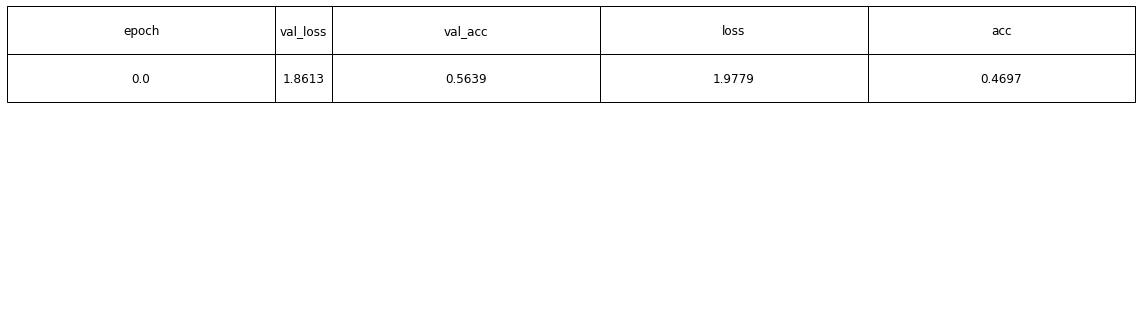

In [119]:
# Table: Fit History
# fig_table_1 = plt.figure(figsize=(15,12))
# fig_table_1 = plt.figure(figsize=(15,10))
fig_table_1 = plt.figure()

# Create axes for this table, but with no visible frame
ax_table = fig_table_1.add_subplot(111, frame_on=False)

# Hide the x and y axes
ax_table.xaxis.set_visible(False)
ax_table.yaxis.set_visible(False)

# Create the table
results_table = plt.table(
            cellText=fit_history_df.values,
#             colWidths = [0.2]*len(table_df.columns),
#             rowLabels=table_df.index,
            colLabels=fit_history_df.columns,
            cellLoc = 'center',
            rowLoc = 'center',
            loc='top')

# Set the fontsize to something readable
results_table.auto_set_font_size(False)
results_table.set_fontsize(12)

# Set the column widths automatically
results_table.auto_set_column_width(True)

# Scale the table
results_table.scale(4,4)

# Show the resulting table
plt.show()
        
# Save the image - use it for Summary of Analysis at the top of the notebook
fig_table_1.savefig('docs/Table-DPA_Fit_History.png', bbox_inches='tight') 

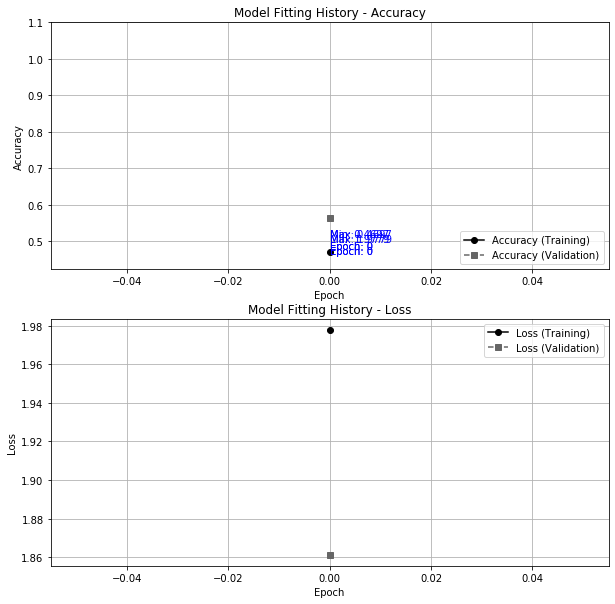

In [120]:
# Plot Epoch history
fig1 = plt.figure(figsize=(10,10))

# Create a single plot of all results
ax1 = fig1.add_subplot( 2,1,1 )
ax2 = fig1.add_subplot( 2,1,2 )

# X-axis
x_vals = range(len(hist.history['acc']))

# Plots
ax1.set_ylim( ymin=0.9*min(hist.history['acc'] + hist.history['val_acc']), ymax=1.1)

ax1.plot( x_vals, hist.history['acc'], label='Accuracy (Training)', c='k', marker='o', linestyle='-')
ax1.plot( x_vals, hist.history['val_acc'], label='Accuracy (Validation)', c='0.4', marker='s', linestyle='--')

ax2.plot( x_vals, hist.history['loss'], label='Loss (Training)', c='k', marker='o', linestyle='-')
ax2.plot( x_vals, hist.history['val_loss'], label='Loss (Validation)', c='0.4', marker='s', linestyle='--')

# Add text note on the max and min accuracy and loss points
acc_min_idx = np.argmin(hist.history['acc'])
ax1.text( x=acc_min_idx, y=hist.history['acc'][acc_min_idx]*1.02, c='b',
          s=f"Min: {hist.history['acc'][acc_min_idx]:.4f}\nEpoch: {acc_min_idx}" )

acc_max_idx = np.argmax(hist.history['acc'])
ax1.text( x=acc_max_idx, y=hist.history['acc'][acc_max_idx]*1.02, c='b',
          s=f"Max: {hist.history['acc'][acc_max_idx]:.4f}\nEpoch: {acc_max_idx}" )

loss_min_idx = np.argmin(hist.history['loss'])
ax2.text( x=loss_min_idx, y=hist.history['loss'][loss_min_idx]*1.02, c='b',
          s=f"Min: {hist.history['loss'][loss_min_idx]:.4f}\nEpoch: {loss_min_idx}" )
         
loss_max_idx = np.argmax(hist.history['loss'])
ax2.text( x=loss_max_idx, y=hist.history['loss'][loss_max_idx]*1.02, c='b',
          s=f"Max: {hist.history['loss'][loss_max_idx]:.4f}\nEpoch: {loss_max_idx}" )

# If populated, plot the loss and accuracy from the test samples
try:
    loss_val = m_score_list[0]
    acc_val = m_score_list[1]

    ax1.text( x=min(x_vals), y=acc_val*1.02, c='darkgreen', s=f"{acc_val:.4f}")
    ax1.hlines(y=acc_val, xmin=min(x_vals), xmax=max(x_vals),
              label='Accuracy (Testing)', color='g', linewidth=1, linestyle=':')    
    
    ax2.text( x=min(x_vals), y=loss_val*0.97, c='darkgreen', s=f"{loss_val:.4f}")
    ax2.hlines(y=loss_val, xmin=min(x_vals), xmax=max(x_vals),
              label='Loss (Testing)', color='g', linewidth=1, linestyle=':')    
except:
    pass
    
ax1.legend(loc='lower right')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Model Fitting History - Accuracy")
ax1.grid(True)

ax2.legend(loc='upper right')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Model Fitting History - Loss")
ax2.grid(True)
         
# Save the image
fig1.savefig("docs/Figure-DPA_Fit_History.png")

In [32]:
# Predict the output (using the test_generator)
test_generator.reset()
pred_onehot = model.predict_generator(test_generator,
                             steps=test_n_step_size,
                             verbose=1)

predicted_class = np.argmax(pred_onehot, axis=1)
# predicted_class

733/733 [==============================] - 107s 146ms/step


In [121]:
# Ensure the predicted labels are all strings for comparison with the actual label
predicted_y = [ str(x) for x in predicted_class ]
# predicted_y

In [122]:
# The actual labels are already strings
# actual_y = [ str(x) for x in y_test ]
actual_y = list(y_test)
# actual_y

In [123]:
# Generate the confusion matrix for this prediction
test_cm = confusion_matrix(actual_y, predicted_y )
test_cm

array([[293,   0,  71,   0,   0],
       [ 14,   0,  62,   0,   0],
       [ 30,   0, 156,   0,   0],
       [ 24,   0,  16,   0,   0],
       [ 15,   0,  52,   0,   0]], dtype=int64)

In [124]:
test_accuracy = accuracy_score(actual_y, predicted_y )
test_accuracy

0.6125511596180082

In [125]:
test_precision = precision_score(actual_y, predicted_y, average='micro' )
test_precision

0.6125511596180082

In [126]:
test_recall = recall_score(actual_y, predicted_y, average='micro' )
test_recall

0.6125511596180082

In [127]:
test_f1 = f1_score(actual_y, predicted_y, average='micro' )
test_f1

0.6125511596180082

In [128]:
# Save the prediction results to a file

# Get the list of test image id codes used by the test generator to make the predictions
# test_id_code_list = [ (x.split("\\"))[1].replace(".png","") for x in test_generator.filenames ]
test_id_code_list = [ x.replace(".png","") for x in test_generator.filenames ]

# Associate the test image id codes and the predictions in a dataframe
# NOTE: Using `predicted_class` (which has integer labels) vs. `predicted_y` (which has string labels)
results_df = pd.DataFrame({"id_code": test_id_code_list, "diagnosis": predicted_class})
results_df.to_csv("./data/prediction_results.csv",index=False)

In [129]:
# Save the model to a file
model.save("./saved_model.h5")

# Predict the Class for Official Test Images

## Load the Saved Convolutional Neural Network Model

In [130]:
# Load a saved model
# model = load_model("./saved_model-96x96,64,128.h5")
model = load_model("./saved_model.h5")

## Plot the Model Fit History

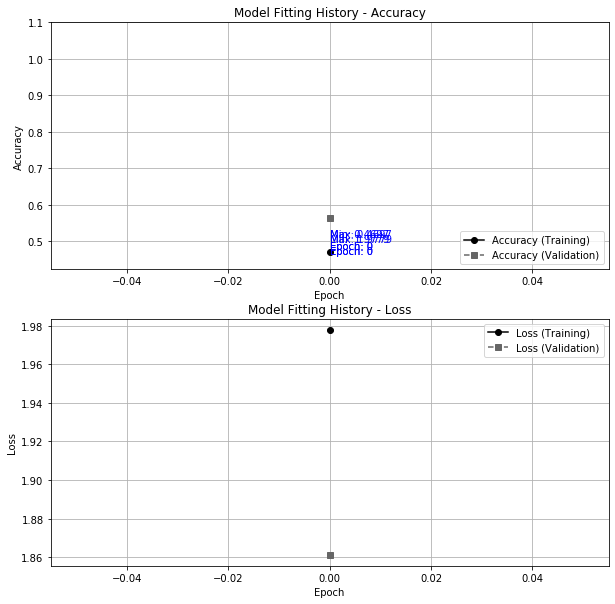

In [131]:
# Plot Epoch history
fig1 = plt.figure(figsize=(10,10))

# Create a single plot of all results
ax1 = fig1.add_subplot( 2,1,1 )
ax2 = fig1.add_subplot( 2,1,2 )

# X-axis
x_vals = range(len(hist.history['acc']))

# Plots
ax1.set_ylim( ymin=0.9*min(hist.history['acc'] + hist.history['val_acc']), ymax=1.1)

ax1.plot( x_vals, hist.history['acc'], label='Accuracy (Training)', c='k', marker='o', linestyle='-')
ax1.plot( x_vals, hist.history['val_acc'], label='Accuracy (Validation)', c='0.4', marker='s', linestyle='--')

ax2.plot( x_vals, hist.history['loss'], label='Loss (Training)', c='k', marker='o', linestyle='-')
ax2.plot( x_vals, hist.history['val_loss'], label='Loss (Validation)', c='0.4', marker='s', linestyle='--')

# Add text note on the max and min accuracy and loss points
acc_min_idx = np.argmin(hist.history['acc'])
ax1.text( x=acc_min_idx, y=hist.history['acc'][acc_min_idx]*1.02, c='b',
          s=f"Min: {hist.history['acc'][acc_min_idx]:.4f}\nEpoch: {acc_min_idx}" )

acc_max_idx = np.argmax(hist.history['acc'])
ax1.text( x=acc_max_idx, y=hist.history['acc'][acc_max_idx]*1.02, c='b',
          s=f"Max: {hist.history['acc'][acc_max_idx]:.4f}\nEpoch: {acc_max_idx}" )

loss_min_idx = np.argmin(hist.history['loss'])
ax2.text( x=loss_min_idx, y=hist.history['loss'][loss_min_idx]*1.02, c='b',
          s=f"Min: {hist.history['loss'][loss_min_idx]:.4f}\nEpoch: {loss_min_idx}" )
         
loss_max_idx = np.argmax(hist.history['loss'])
ax2.text( x=loss_max_idx, y=hist.history['loss'][loss_max_idx]*1.02, c='b',
          s=f"Max: {hist.history['loss'][loss_max_idx]:.4f}\nEpoch: {loss_max_idx}" )

# If populated, plot the loss and accuracy from the test samples
try:
    loss_val = m_score_list[0]
    acc_val = m_score_list[1]

    ax1.text( x=min(x_vals), y=acc_val*1.02, c='darkgreen', s=f"{acc_val:.4f}")
    ax1.hlines(y=acc_val, xmin=min(x_vals), xmax=max(x_vals),
              label='Accuracy (Testing)', color='g', linewidth=1, linestyle=':')    
    
    ax2.text( x=min(x_vals), y=loss_val*0.97, c='darkgreen', s=f"{loss_val:.4f}")
    ax2.hlines(y=loss_val, xmin=min(x_vals), xmax=max(x_vals),
              label='Loss (Testing)', color='g', linewidth=1, linestyle=':')    
except:
    pass
    
ax1.legend(loc='lower right')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Model Fitting History - Accuracy")
ax1.grid(True)

ax2.legend(loc='upper right')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Model Fitting History - Loss")
ax2.grid(True)
         
# Save the image
fig1.savefig("docs/Figure-DPA_Fit_History.png")

## Configure the Image Generator for the Official Test Images

In [133]:
# Summary
print(f"Using Testing Folders and Files:")
print(f"\tTesting Labels File: '{test_labels_file}'")
print(f"\tTesting Image Directory: '{dir_test_src}'")
print(f"\tTemporary Augmented Image Directory: '{dir_temp_aug_images}'")
print(f"\tFlag to Save Augmented Images: {flag_save_aug}")

Using Testing Folders and Files:
	Testing Labels File: './data/test.csv'
	Testing Image Directory: './data/test_images/'
	Temporary Augmented Image Directory: './data/temp_aug_images/'
	Flag to Save Augmented Images: False


In [134]:
# Load test counts into a dataframe
test_image_list_df = pd.read_csv(test_labels_file)
test_image_list_df['id_code_fn'] = test_image_list_df['id_code'] + ".png"
len(test_image_list_df)

1928

In [135]:
# Create a Image Data Generator for the official testing data
official_test_datagen = ImageDataGenerator()

# Define generator batch size and step size
official_test_n_images = len(test_tally_df)
official_test_n_batch_size = 1
official_test_n_step_size = official_test_n_images // official_test_n_batch_size

# Associate the generator with the training images
official_test_generator = official_test_datagen.flow_from_dataframe(
    dataframe=test_image_list_df,                    # Dataframe with filenames of images and column for labels
    directory=dir_test_src,                     # Directory containing images used for training, validation, and testing
    x_col='id_code_fn',                         # Column containing filenames of images in directory dir_train_src
    target_size=(image_dims[1], image_dims[0]), # The (height, width) to which each image will be resized
    color_mode='rgb',                           # Images will be color ('rgb') (3 color channels) vs. 'grayscale'
    batch_size=official_test_n_batch_size,      # Batch size
    class_mode=None,                            # Performing prediction only, no labels provided
    shuffle=False,                              # Don't shuffle the input samples
    seed=1,                                     # Random number seed - only needed if shuffling
    save_to_dir=dir_temp_aug_images if flag_save_aug else None, # Directory to save aug images if flag is True
    save_prefix='official_test_aug_',           # Prefix to apply to any saved images
    save_format='png',                          # File format to appy to any saved images
    interpolation='bicubic'                     # Interpolation method used to resize samples
)

Found 1928 validated image filenames.


## Predict the Classifications based upon the Images

In [136]:
# Predict the output (using the test_generator)
official_test_generator.reset()
official_pred_onehot = model.predict_generator(official_test_generator,
                             steps=len(official_test_generator),
                             verbose=1)

official_predicted_class = np.argmax(official_pred_onehot, axis=1)
official_predicted_class

1928/1928 [==============================] - 132s 68ms/step


array([2, 0, 0, ..., 0, 0, 0], dtype=int64)

## Save the Predictions from the Official Test Data

In [137]:
# Save the prediction results to a file

# Get the list of test image id codes used by the test generator to make the predictions
official_test_id_code_list = [ x.replace(".png","") for x in official_test_generator.filenames ]

# Associate the test image id codes and the preoductions in a dataframe
official_results_df = pd.DataFrame({"id_code": official_test_id_code_list, "diagnosis": official_predicted_class})
official_results_df.to_csv("./submission.csv",index=False)
official_results_df

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,2
4,009245722fa4,0
...,...,...
1923,ff2fd94448de,0
1924,ff4c945d9b17,0
1925,ff64897ac0d8,0
1926,ffa73465b705,0
